In [ ]:
!pip install openai
!pip install lckr_jupyterlab_variableinspector


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from openai.types.beta.threads import ImageFileContentBlock
from pathlib import Path
from data_processing.process_data import process_speckle_data
import json

In [ ]:
import os
API_KEY = os.environ["OPENAI_API_KEY"]

In [ ]:
from openai import OpenAI

client = OpenAI(api_key=API_KEY)

assistant = client.beta.assistants.create(
  instructions="""
      You are an AI assistant that will allow users to talk to 
      their data-rich models. In the responses where you're running code, 
      do not provide any additional response besides the code and the output 
      of the code, and also always run the code.I will provide you with json files 
      that contain data that were either made from Speckle or from IfcOpenShell and 
      you need to be able to read this data and perform analysis on it. You will need 
      to extract the properties and attributes from the various objects that are 
      provided to learn about them and what can be analysed about them. Before 
      providing any visualisations, really make sure that the necessary data is actually present. 
      If there's an open-ended question from the user, make a choice regarding what to provide. 
      Do not ask the user to choose unless it's 100% necessary.
      """,
  model="gpt-4o-2024-05-13",
  tools=[{"type": "code_interpreter"}]
)

In [4]:
test_files_folder = 'static/test_files'
data_source = 'speckle'
# file_name = 'MEP_OLVG_test'
file_name = 'revit_advanced_sample_structural'

file = None
# file_description = None
instructions_file = None
if data_source == 'speckle':
    with open(f"{test_files_folder}/{data_source}/{file_name}.json", "r") as fp:
        processed_data = process_speckle_data(json.load(fp))
    temp_json_path = Path.cwd() / test_files_folder / data_source / 'temp' / f"PROCESSED_{file_name}.json"
    temp_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(temp_json_path, 'w+') as fp:
        json.dump(processed_data, fp)
    
    file = client.files.create(
        # file=json.dumps(processed_data).encode('utf-8'),
        file=open(temp_json_path, "rb"), 
        purpose='assistants')

    instructions_path = Path.cwd() / 
    file = client.files.create(
        file=open(
    )
    # file_description = """
    #     Attached is a json with data from Speckle. Speckle data has lots of attributes and 
    #     is quite nested. So an object can have multiple list attributes attached to it, 
    #     which are child objects representing parameters of the parent object. It's always 
    #     important to explore whether the object has such lists inside of it and 
    #     whether they should be explored for data analytics. It's also likely that there are
    #     lists of objects where these objects are also attributes of other classes, 
    #     which is important to take into account. If you find that the speckle type is a Collection, 
    #     then it means that it also has an attribute/key called 'elements', in which there are child
    #     objects that are attached to the parent object and are very important to take into account. 
    #     When first exploring the data, first just look into the keys, and then after that for the different 
    #     types or categories of keys, look into the keys of those objects. But for same type objects, we don't 
    #     have to explore the keys again. If you try to explore too much data at once, so all keys and 
    #     values at once for all objects, it's too much for you to handle. In general we are not interested 
    #     in knowing anything about the views or the data structure. I want to get insight into the actual
    #     physical data is in the model.
    #     """
elif data_source == 'ifc':
    pass
else:
    pass

thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": file_description,
      "attachments": [
        {
          "file_id": file.id,
          "tools": [{"type": "code_interpreter"}]
        }
      ]
    }
  ]
)

In [6]:
import json
from pathlib import Path

# First, create the instructions JSON file
instructions = {
    "role": "You are an AI assistant that allows users to interact with and analyze data-rich models, particularly those created from Speckle or IfcOpenShell.",
    "primary_goals": [
        "Read and analyze data from provided JSON files",
        "Extract properties and attributes from various objects",
        "Perform data analysis on the extracted information",
        "Provide insights into the actual physical data in the model"
    ],
    "response_guidelines": [
        "When running code, only provide the code and its output without additional commentary",
        "Always execute the code when it's part of the response",
        "Make choices for open-ended questions unless user input is absolutely necessary",
        "Ensure necessary data is present before providing visualizations"
    ],
    "data_handling": {
        "structure": "Speckle data is highly nested with multiple list attributes",
        "exploration_steps": [
            "First, examine the top-level keys of objects",
            "For different types or categories of keys, explore their sub-keys",
            "For objects of the same type, avoid re-exploring keys",
            "Avoid exploring all keys and values at once to prevent overload"
        ],
        "special_cases": [
            {
                "type": "Collection",
                "action": "Check for 'elements' key containing important child objects"
            }
        ],
        "focus": "Prioritize insight into actual physical data over views or data structure"
    },
    "analysis_approach": [
        "Identify and explore list attributes that may contain child objects",
        "Recognize when objects are attributes of other classes",
        "Consider relationships between parent and child objects",
        "Look for patterns and connections across different object types"
    ],
    "output_preferences": [
        "Provide concise, data-driven insights",
        "Use visualizations when appropriate and data is available",
        "Summarize findings in a clear, structured manner"
    ],
    "error_handling": [
        "If data is missing or inconsistent, clearly state the limitations",
        "Suggest alternative analyses when primary approach is not possible",
        "Admit when certain analyses are not feasible due to data constraints"
    ]
}

# Upload the instructions file
instructions_file = client.files.create(
    file=open(instructions_path, "rb"),
    purpose='assistants'
)

# Create the assistant without file_ids
assistant = client.beta.assistants.create(
    name="Speckle Data Analyzer",
    instructions="Please refer to the attached JSON file for your complete instructions.",
    model="gpt-4o-2024-05-13",
    tools=[{"type": "code_interpreter"}]
)

# Attach the file to the assistant after creation
client.beta.assistants.files.create(
    assistant_id=assistant.id,
    file_id=instructions_file.id
)

# Set up the data file
test_files_folder = 'static/test_files'
data_source = 'speckle'
file_name = 'revit_advanced_sample_structural'
file = None

if data_source == 'speckle':
    with open(f"{test_files_folder}/{data_source}/{file_name}.json", "r") as fp:
        processed_data = process_speckle_data(json.load(fp))
    temp_json_path = Path.cwd() / test_files_folder / data_source / 'temp' / f"PROCESSED_{file_name}.json"
    temp_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(temp_json_path, 'w') as fp:
        json.dump(processed_data, fp)
    
    file = client.files.create(
        file=open(temp_json_path, "rb"), 
        purpose='assistants'
    )

# Create the thread with the data file
thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Attached is a JSON file containing Speckle data for analysis. Please explore this data according to your instructions.",
            "file_ids": [file.id]
        }
    ]
)

# Run the assistant
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions="Analyze the attached Speckle data file and provide an initial overview of its contents."
)

# You can then check the run status and retrieve the assistant's response
# This part depends on how you want to handle the asynchronous nature of the Runs API

AttributeError: 'Assistants' object has no attribute 'files'

In [6]:
from typing_extensions import override
from openai import AssistantEventHandler

# First, we create a EventHandler class to define
# how we want to handle the events in the response stream.

class EventHandler(AssistantEventHandler):
  @override
  def on_text_created(self, text) -> None:
    print(f"\nassistant > ", end="", flush=True)

  @override
  def on_text_delta(self, delta, snapshot):
    print(delta.value, end="", flush=True)

  def on_tool_call_created(self, tool_call):
    print(f"\nassistant > {tool_call.type}\n", flush=True)

  def on_tool_call_delta(self, delta, snapshot):
    if delta.type == 'code_interpreter':
      if delta.code_interpreter.input:
        print(delta.code_interpreter.input, end="", flush=True)
      if delta.code_interpreter.outputs:
        print(f"\n\noutput >", flush=True)
        for output in delta.code_interpreter.outputs:
          if output.type == "logs":
            print(f"\n{output.logs}", flush=True)

In [7]:
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="""
      What can you tell me about this model? Please provide me with a few visualisations
      that visualise some aspect of the model to give me some interesting insight 
      into it.
  """,
  event_handler=EventHandler(),
) as stream:
  stream.until_done()


assistant > Alright! Let's start by loading the JSON file and examining its structure to understand the objects and keys it contains. We'll begin by loading the data and viewing the top-level keys. Then we'll progressively explore nested models as needed.
assistant > code_interpreter

import json

# Load the JSON data
file_path = '/mnt/data/file-DCrcAlDT8lh8iksPeaJvz3B4'
with open(file_path, 'r') as file:
    data = json.load(file)

# Get the top-level keys
top_level_keys = data.keys()
top_level_keys
assistant > It appears that the JSON file might contain a string or a format that we're not directly treating as a dictionary. Let's first inspect the first few characters of the content to understand its structure. We'll then proceed accordingly.# Reload the file and check its content
with open(file_path, 'r') as file:
    content = file.read()

# Print the first 500 characters to get a sense of its structure
content[:500]
assistant > The content is a JSON string with escaped characters.

In [8]:
from pathlib import Path
from IPython.display import Image, display, Markdown

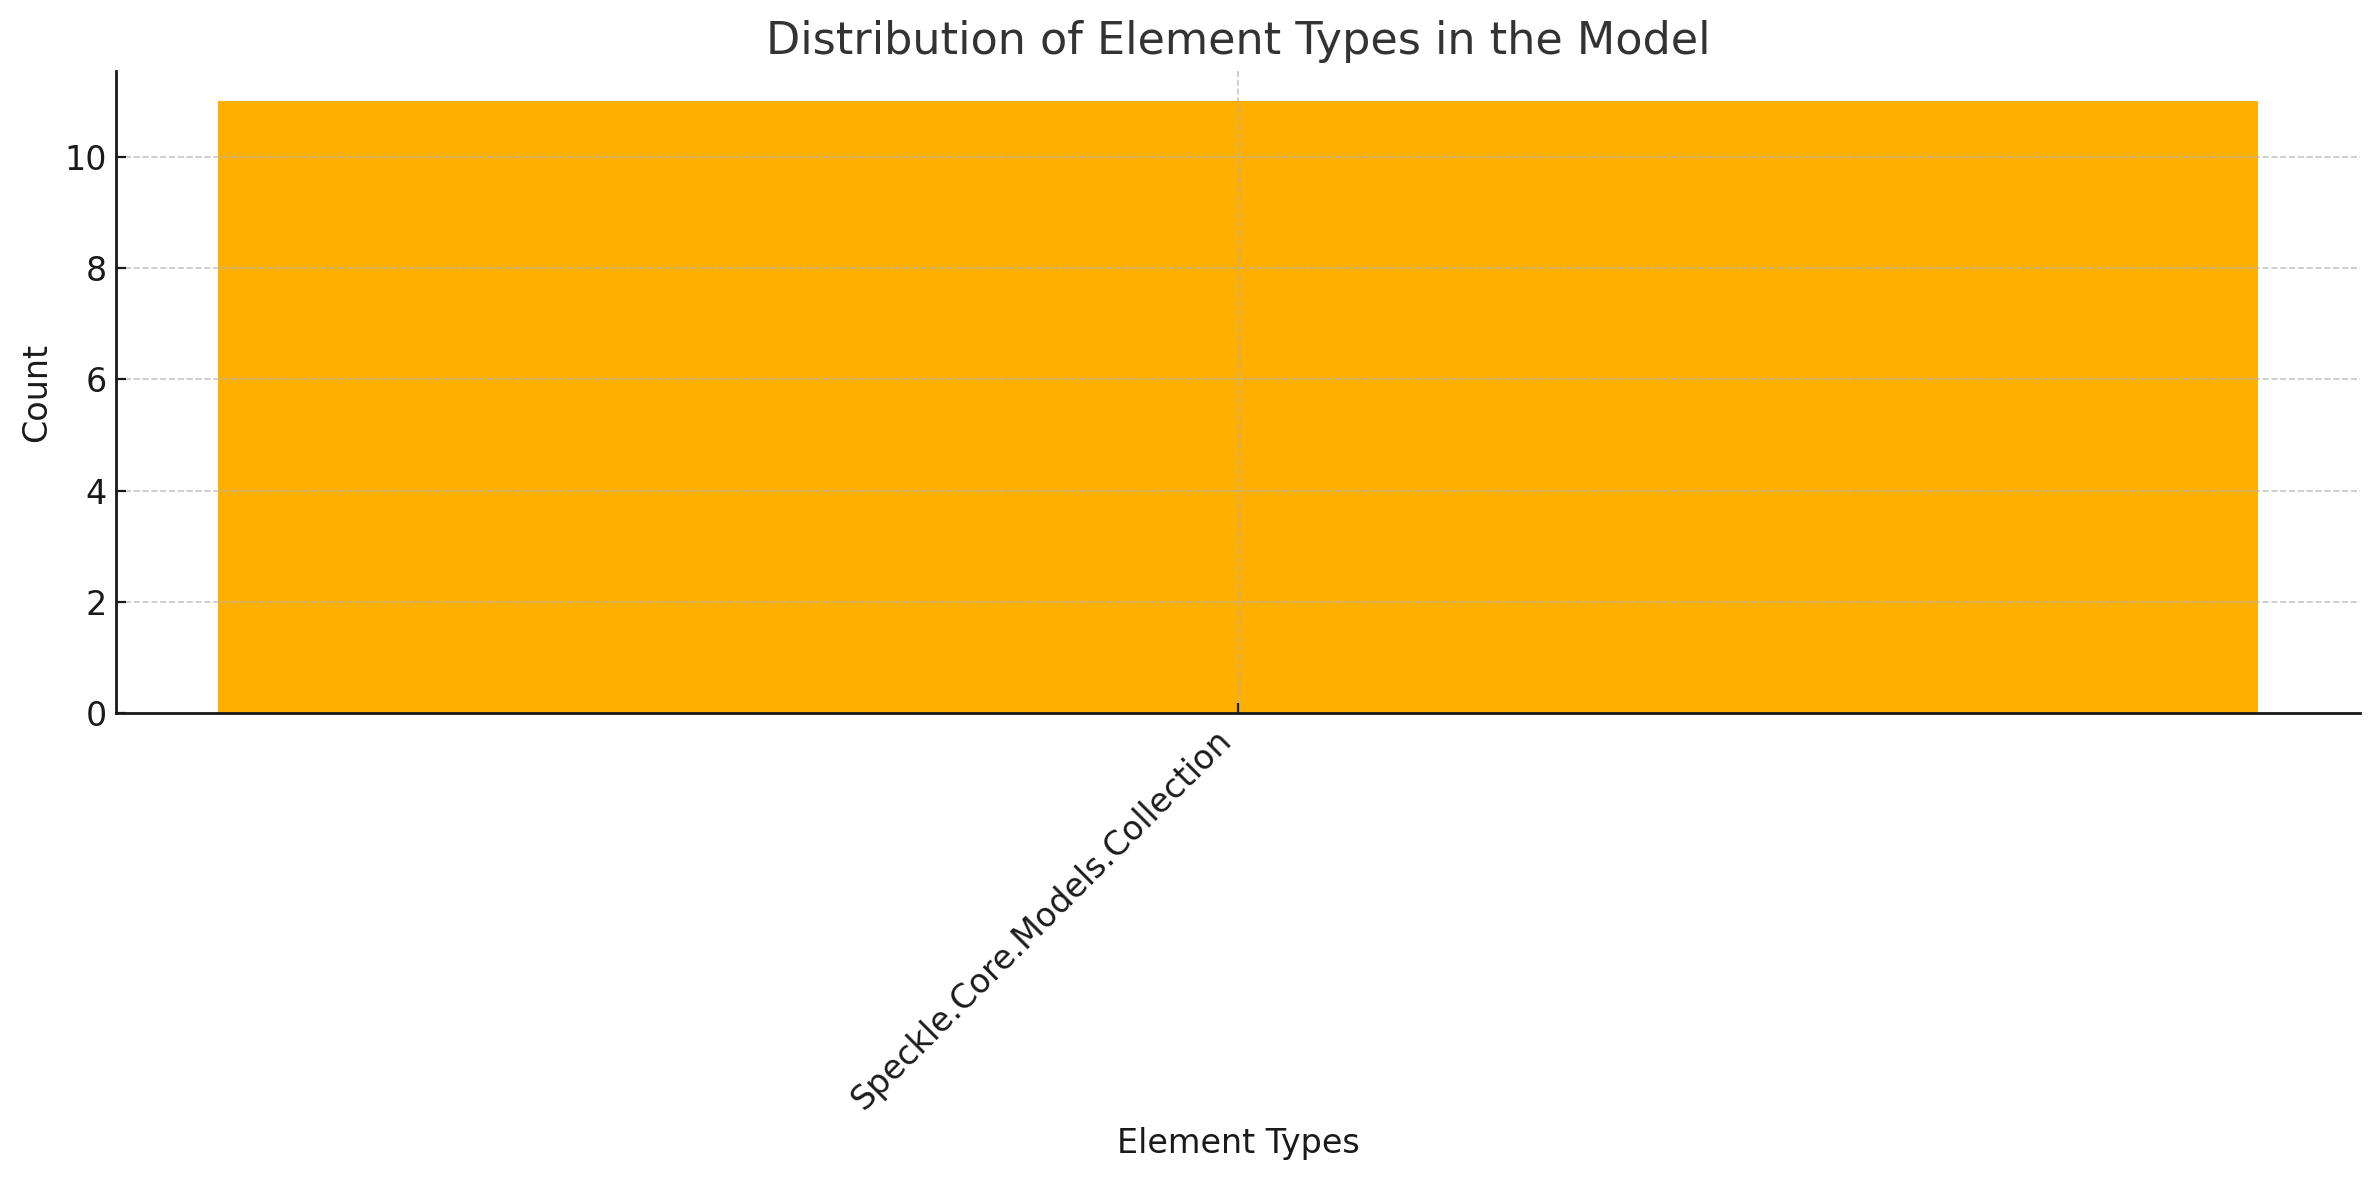

The plot above shows that all the top-level elements in the model are of the type `Speckle.Core.Models.Collection`. This indicates that the model is heavily structured around collections containing nested elements.

Next, let's dive a bit deeper into these nested elements to see the distribution and characteristics of more specific types of elements (such as structural columns, beams, etc.) within the first few nested collections. We'll visualize the types of elements contained within one of these collections in detail.

The first element within the main `'elements'` list contains 203 nested elements. The first of these nested elements has the following characteristics:

- **Type**: `Objects.BuiltElements.Column:Objects.BuiltElements.Revit.RevitColumn`
- **Keys**:
  - `'id'`
  - `'speckle_type'`
  - `'totalChildrenCount'`
  - `'applicationId'`
  - `'baseLine'`
  - `'baseOffset'`
  - `'builtInCategory'`
  - `'category'`
  - `'displayValue'`
  - `'elementId'`
  - `'facingFlipped'`
  - `'family'`
  - `'handFlipped'`
  - `'isRevitLinkedModel'`
  - `'isSlanted'`
  - `'level'`
  - `'materialQuantities'`
  - `'parameters'`
  - `'phaseCreated'`
  - `'revitLinkedModelPath'`
  - `'rotation'`
  - `'topLevel'`
  - `'topOffset'`
  - `'type'`
  - `'units'`
  - `'worksetId'`

This nested structure provides a wealth of information, and it appears to describe specific architectural or structural elements, such as columns in this case.

Next, let's visualize the key distribution within the main `'elements'` list to see how these objects are distributed by their `'speckle_type'`, which might give us an interesting insight into the model's composition.

The `'elements'` key contains a list of 11 elements. The first element within this list has the following characteristics:

- **Type**: `Speckle.Core.Models.Collection`
- **Keys**: 
  - `'id'`
  - `'speckle_type'`
  - `'totalChildrenCount'`
  - `'applicationId'`
  - `'collectionType'`
  - `'elements'` (indicating further nested elements)
  - `'name'`
  - `'units'`

This structure suggests that we have a hierarchical structure with nested collections. To provide interesting insights into the actual physical data, let's explore a bit deeper into the first few elements' nested `'elements'`. We'll dive two levels deep to understand their structure and attributes better.

The top-level keys in the JSON structure are:

- `'id'`
- `'speckle_type'`
- `'totalChildrenCount'`
- `'@Types'`
- `'applicationId'`
- `'collectionType'`
- `'elements'`
- `'info'`
- `'name'`
- `'units'`

Given your instructions, let's delve into these keys, paying special attention to nested objects, especially the key `'elements'` which could contain child objects as it is likely of the collection type. We'll explore the structure further step-by-step. 

Let's examine the value associated with the `'elements'` key.

Great! Now we've successfully parsed the JSON content into a dictionary. Let's proceed to inspect the top-level keys of this dictionary to understand its structure.

It seems that the content is still being interpreted as a string even after attempting to decode it. This suggests that there might be multiple layers of encoding. Let's try decoding it again.

It seems the content still appears to be read as a string even after decoding. Let's ensure that the decoding step fully converts it into a JSON object. I'll iterate further to troubleshoot and correctly parse the structure.

The content is a JSON string with escaped characters. Let me decode it properly into a JSON object and then explore the structure from there.

It appears that the JSON file might contain a string or a format that we're not directly treating as a dictionary. Let's first inspect the first few characters of the content to understand its structure. We'll then proceed accordingly.

Alright! Let's start by loading the JSON file and examining its structure to understand the objects and keys it contains. We'll begin by loading the data and viewing the top-level keys. Then we'll progressively explore nested models as needed.


        Attached is a json with data from Speckle. Speckle data has lots of attributes and 
        is quite nested. So an object can have multiple list attributes attached to it, 
        which are child objects representing parameters of the parent object. It's always 
        important to explore whether the object has such lists inside of it and 
        whether they should be explored for data analytics. It's also likely that there are
        lists of objects where these objects are also attributes of other classes, 
        which is important to take into account. If you find that the speckle type is a Collection, 
        then it means that it also has an attribute/key called 'elements', in which there are child
        objects that are attached to the parent object and are very important to take into account. 
        When first exploring the data, first just look into the keys, and then after that for the different 
        types or categories of keys, look into the keys of those objects. But for same type objects, we don't 
        have to explore the keys again. If you try to explore too much data at once, so all keys and 
        values at once for all objects, it's too much for you to handle. In general we are not interested 
        in knowing anything about the views or the data structure. I want to get insight into the actual
        physical data is in the model.
        

In [9]:
messages = client.beta.threads.messages.list(thread_id=thread.id)
file_ids = []
new_messages = []
image_id = 0
temp_path = Path.cwd() / 'temp'
temp_path.mkdir(exist_ok=True, parents=True)
for msg in messages.data:
  for cont in msg.content:
        if isinstance(cont, ImageFileContentBlock):
            image_id += 1
            img_response = client.files.with_raw_response.retrieve_content(cont.image_file.file_id)
            content = img_response.content
            new_messages.append({"type": "img", "value": content})
            with open(f'temp/image_{image_id}.png', 'wb') as f:
                f.write(content)
                display(Image(filename=f'temp/image_{image_id}.png'))
        else:
            new_messages.append({"type": "text", "value": cont.text.value})
            display(Markdown(cont.text.value))


In [41]:
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="""
      Something regarding the air handling units would be great.
  """,
  event_handler=EventHandler(),
) as stream:
  stream.until_done()


assistant > code_interpreter

# Let's start by exploring the structure of the 'AirHandlingUnits' key

air_handling_units = data.get('AirHandlingUnits', [])
air_handling_units_summary = {
    'total_units': len(air_handling_units),
    'first_unit_keys': air_handling_units[0].keys() if air_handling_units else "No air handling units available"
}
air_handling_units_summary
assistant > The `AirHandlingUnits` key contains 14 items. Each air handling unit (AHU) object has the following attributes:
- `id`
- `speckle_type`
- `ahu_id`
- `components`
- `configuration`
- `description`
- `height`
- `length`
- `meta_data`
- `name`
- `parameters`
- `return_mechanical_man`
- `return_mechanical_req`
- `size_return_man`
- `size_return_req`
- `size_supply_man`
- `size_supply_req`
- `supply_mechanical_man`
- `supply_mechanical_req`
- `type`
- `units`
- `warnings`
- `width`

Let's extract some critical attributes, like `height`, `length`, `width`, and analyze their distribution. This will give us an idea

In [10]:
messages = client.beta.threads.messages.list(thread_id=thread.id)
file_ids = []
new_messages = []
image_id = 0
temp_path = Path.cwd() / 'temp'
temp_path.mkdir(exist_ok=True, parents=True)
for msg in messages.data:
  for cont in msg.content:
        if isinstance(cont, ImageFileContentBlock):
            image_id += 1
            img_response = client.files.with_raw_response.retrieve_content(cont.image_file.file_id)
            content = img_response.content
            new_messages.append({"type": "img", "value": content})
            with open(f'temp/image_{image_id}.png', 'wb') as f:
                f.write(content)
                display(Image(filename=f'temp/image_{image_id}.png'))
        else:
            new_messages.append({"type": "text", "value": cont.text.value})
            display(Markdown(cont.text.value))


NameError: name 'Markdown' is not defined

In [43]:
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="""
      Can you find something in the data of the objects that seems to be wrong?
  """,
  event_handler=EventHandler(),
) as stream:
  stream.until_done()


assistant > We can explore the `DemandClasses` next to understand different demand categories and their associated attributes. This might highlight the different types of energy or resource demands within the system.

Let's start by examining the structure and contents of the `DemandClasses` key.
assistant > code_interpreter

# Explore the structure of the 'DemandClasses' key

demand_classes = data.get('DemandClasses', [])
demand_classes_summary = {
    'total_classes': len(demand_classes),
    'first_class_keys': demand_classes[0].keys() if demand_classes else "No demand classes available"
}
demand_classes_summary
assistant > It looks like the `DemandClasses` key does not contain any entries in this dataset. Therefore, there's no data to analyze under this category.

Let's move on to another key that might provide meaningful insights. How about exploring `ProjectParameters` next? This could hold important project-specific information.

We'll examine the structure and contents of the 

In [44]:
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="""
      Can you calculate and visualise something interesting across the spaces per room function (typology)?
  """,
  event_handler=EventHandler(),
) as stream:
  stream.until_done()


assistant > To continue extracting value from this Speckle data, we could now explore the `Typologies` section. This may give insights into the functional groupings or classifications of the spaces within the dataset.

Let's examine the structure and contents of the `Typologies` key.
assistant > code_interpreter

# Explore the structure of the 'Typologies' key

typologies = data.get('Typologies', [])
typologies_summary = {
    'total_typologies': len(typologies),
    'first_typology_keys': typologies[0].keys() if typologies else "No typologies available"
}
typologies_summary
assistant > The `Typologies` key contains 9 items. Each typology object has the following attributes:
- `id`
- `speckle_type`
- `comfort_class`
- `demands`
- `gmp_class`
- `meta_data`
- `name`
- `typo_id`
- `units`
- `warnings`

To begin, let's summarize some of these attributes like `name`, `comfort_class`, and `gmp_class`. This will provide an overview of the different typologies available in the dataset.# Extra